In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
import random
import time
import json
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams['figure.figsize'] = (15, 7)

# MAE and Data classes

## Data

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader


class DataManagement():
    def __init__(self,
                 data,
                 features,
                 targets_features,
                 inseqlen=7,
                 outseqlen=7,
                 normalize_data=True
        ):
        super().__init__()

        self.data = data
        self.features = features
        self.targets_features = targets_features
        self.inseqlen = inseqlen
        self.outseqlen = outseqlen
        if normalize_data:
            self.data_normalization = 'MinMax'
            self.data_normalize()

    def data_normalize(self):
        if self.data_normalization == 'MinMax':
            self.scaler = MinMaxScaler()
            self.data[self.data.columns] = self.scaler.fit_transform(self.data[self.data.columns])

        self.data = self.data[~self.data.index.duplicated(keep='first')]

    def data_tensor_generate(self, input_len, output_len):
        if input_len:
            self.inseqlen = input_len
        if output_len:
            self.outseqlen = output_len

        window_dataset = self.data.iloc[:-self.outseqlen].rolling(self.inseqlen, min_periods=1, win_type=None, center=False)

        inputs, targets = [], []
        for window in window_dataset:
            if len(window) == self.inseqlen:
                inpt = window[self.features]
                inputs.append(inpt.T.values)
                last_inpt_day = pd.Timestamp(inpt.index[-1])
                next_day_after_last = last_inpt_day + pd.DateOffset(1)
                start_pred_range = next_day_after_last
                data_forward_range = pd.date_range(start=start_pred_range, periods=self.outseqlen)
                trg = self.data[self.targets_features].loc[data_forward_range]
                targets.append(trg.T.values)

        self.inputs_tensor = torch.Tensor(np.array(inputs))
        self.targets_tensor = torch.Tensor(np.array(targets))

    def set_as_train_data(self, x, y):
        self.X_train = x
        self.Y_train = y
    
    def set_as_test_data(self, x, y):
        self.X_test = x
        self.Y_test = y
    
    def train_test_split(self, prct_to_train=0.8):
        self.percent_to_train = prct_to_train
        x_to_train = self.inputs_tensor[:int(len(self.inputs_tensor)*prct_to_train)]
        y_to_train = self.targets_tensor[:int(len(self.targets_tensor)*prct_to_train)]
        self.set_as_train_data(x_to_train, y_to_train)

        x_to_test = self.inputs_tensor[int(len(self.inputs_tensor)*prct_to_train):]
        y_to_test = self.targets_tensor[int(len(self.targets_tensor)*prct_to_train):]
        self.set_as_test_data(x_to_test, y_to_test)

    def dataloader_train_generate(self, batch_size=32):
        self.batch_size = batch_size
        self.data_train_tensor = TensorDataset(self.X_train, self.Y_train)
        self.data_train = DataLoader(self.data_train_tensor, batch_size=batch_size, shuffle=False)
    
    def dataloader_test_generate(self, batch_size=32):
        self.batch_size = batch_size
        self.data_test_tensor = TensorDataset(self.X_test, self.Y_test)
        self.data_test = DataLoader(self.data_test_tensor, batch_size=batch_size, shuffle=False)

    def dataloader_create(self, batch_size=32):
        self.dataloader_train_generate(batch_size)
        self.dataloader_test_generate(batch_size)
    
    def data_to_test_create(self, data_test=None):
        if data_test is not None:
            self.data_to_test = data_test
        else:
            self.data_to_test = self.data

        data_test_vect = []
        for i in range(0, len(self.data_to_test), self.outseqlen):
            window = self.data_to_test[self.features][i: i+self.inseqlen]
            if len(window) == self.inseqlen:
                data_test_vect.append(window.T.values)

        self.data_to_test = torch.Tensor(np.array(data_test_vect))
    
    def data_split_by_feature(self):
        features_splitted = []
        for i in range(self.X_train.shape[1]):
            ft = torch.Tensor([input[i].numpy() for input in self.X_train])
            ft_dataset = TensorDataset(ft, ft)
            ft_dataloader = DataLoader(ft_dataset, batch_size=self.batch_size, shuffle=False)
            features_splitted.append(ft_dataloader)
        
        self.splited_data = features_splitted
    
    def att_data(self, new_features, new_targets_features, data=None):
        if data:
            self.data = data
        self.features = new_features
        self.targets_features = new_targets_features

        self.data_tensor_generate(self.inseqlen, self.outseqlen)
        self.train_test_split(self.percent_to_train)
        self.dataloader_create(self.batch_size)
        self.data_split_by_feature()

## MAE

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

class ModifiedAutoEncoder(nn.Module):
    def __init__(self, atribucts_dict):
        super().__init__()
        
        for item, value in atribucts_dict.items():
            setattr(self, item, value)

        self.autoencoders_counter = 0

        if self.seed:
            self.fix_seed(self.seed)

        self.encoders, self.decoders, self.predictors = nn.ModuleList(), nn.ModuleList(), nn.ModuleList()
        self.generate_autoencoders()
        self.generate_predictors()

    def fix_seed(self, seed):
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)

    def generate_autoencoders(self):
        for _ in range(self.n_features):
            self.add_autoencoder()
    
    def add_autoencoder(self):
        self.add_encoder()
        self.add_decoder()
        self.autoencoders_counter = self.autoencoders_counter + 1
        if self.is_an_appended_autoencoder():
            self.att_predictors()

    def is_an_appended_autoencoder(self):
        if self.n_features < self.autoencoders_counter:
            self.n_features = self.autoencoders_counter
            return True
        else:
            return False 

    def add_encoder(self):
        self.encoders.append(nn.Sequential(nn.Linear(self.inseqlen, self.growth * self.inseqlen),
                                getattr(nn, self.activation)(),
                                nn.Linear(self.growth * self.inseqlen, self.latent_space_dim)))

    def add_decoder(self):
        self.decoders.append(nn.Sequential(nn.Linear(self.latent_space_dim, self.growth * self.inseqlen),
                                getattr(nn, self.activation)(),
                                nn.Linear(self.growth * self.inseqlen, self.inseqlen)))

    def generate_predictors(self):
        for _ in range(self.n_targets):
            self.add_predictor()
    
    def add_predictor(self):
        self.predictors.append(nn.Sequential(nn.Linear(self.n_features * self.latent_space_dim, self.outseqlen)))

    def att_predictors(self):
        self.predictors = nn.ModuleList([nn.Sequential(nn.Linear(self.n_features * self.latent_space_dim, self.outseqlen)) for _ in range(self.n_targets)])

    def forward(self, batch):
        encoded_batch, decoded_batch = self.forward_autoencoders(batch)
        predict_batch = self.forward_predictors(encoded_batch)

        return decoded_batch, predict_batch
    
    def forward_autoencoders(self, batch):
        encoded_batch, decoded_batch = [], []
        for input in batch:
            encoded_batch.append([encoder(xs) for encoder, xs in zip(self.encoders, input)])
        # stack is used to transform a list of tensor in a unic tensor of tensor
        for enc in encoded_batch:
            decoded_batch.append(torch.stack([decoder(z) for decoder, z in zip(self.decoders, enc)]))
        return encoded_batch, torch.stack(decoded_batch)
        
    def forward_predictors(self, encoded_batch):
        predict_batch = []
        # stack is used to transform a list of tensor in a unic tensor of tensor
        for enc in encoded_batch:
            predict_batch.append(torch.stack([predictor(torch.cat(enc, dim=-1)) for predictor in self.predictors]))
        return torch.stack(predict_batch)

    def train_joined(self,
                     data_instance: DataManagement,
                     validation: bool = True
        ) -> None:

        self.data_train = data_instance.data_train
        self.validation = validation
        if self.validation:
            self.data_validation = data_instance.data_test
        
        epochs = range(self.epochs)

        self.loss_train, self.loss_val = [], []
        start = time.time()
        for epoch in epochs:
            for batch_train in self.data_train:
                inputs, targets = batch_train
                forward_output = self.forward(inputs)

                loss = self.joined_loss_calculation(batch_train, forward_output)
                self.weights_adjustment(loss)

            self.loss_train.append(loss.item())

            if self.validation:
                loss_validation = self.train_validation_joined()
                self.loss_val.append(loss_validation.item())

        end = time.time()
        self.elapsed_time = end - start
    
    def train_splitted_freezing_autoencoders_weights(self,
                                                     data_instance: DataManagement,
                                                     validation: bool = True):

        self.set_encoders_weights_unadjustable()
        self.train_splitted_freezing_decoders_weights(data_instance, validation)
        
    def train_splitted_freezing_decoders_weights(self,
                                                 data_instance: DataManagement,
                                                 validation: bool = True):
        self.data_train = data_instance.data_train
        if validation:
            self.data_validation = data_instance.data_test
        self.splitted_feature_data = data_instance.splited_data
        self.validation = validation

        epochs = range(self.epochs)
        start = time.time()

        self.train_all_autoencoders()
        self.set_decoders_weights_unadjustable()

        self.loss_train, self.loss_val = [], []
        for epoch in epochs:
            for batch in self.data_train:
                inputs, targets = batch
                forward_output = self.forward(inputs)

                loss = self.splitted_loss_calculation(batch, forward_output)
                self.weights_adjustment(loss)

            self.loss_train.append(loss.item())

            if self.validation:
                loss_validation = self.train_validation_splitted()
                self.loss_val.append(loss_validation.item())

        end = time.time()
        self.elapsed_time = end - start
    
    def train_additive(self, new_feature):
        autoencoder = [self.encoders[-1], self.decoders[-1]]
        self.train_autoencoder(new_feature, autoencoder)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.train_predictor()

    def train_all_autoencoders(self):
        for idx, feature in enumerate(self.splitted_feature_data):
            autoencoder = [self.encoders[idx], self.decoders[idx]]
            self.train_autoencoder(feature, autoencoder)

    def train_predictor(self):
        epochs = range(self.epochs)
        
        start = time.time()
        self.loss_train, self.loss_val = [], []
        for epoch in epochs:
            for batch in self.data_train:
                inputs, targets = batch
                forward_output = self.forward(inputs)

                loss = self.splitted_loss_calculation(batch, forward_output)
                self.weights_adjustment(loss)

            self.loss_train.append(loss.item())
        end = time.time()
        self.elapsed_time = end - start

    def train_autoencoder(self, feature, autoencoder):
        inner_optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        encoder = autoencoder[0]
        decoder = autoencoder[1]
        for epoch in range(self.epochs):
            for batch in feature:
                inputs, targets = batch
                encoded = encoder(inputs)
                decoded = decoder(encoded)

                loss = self.loss_function(decoded, targets)

                inner_optimizer.zero_grad()
                loss.backward()
                inner_optimizer.step()

    def train_validation_joined(self):
        with torch.no_grad():
            for batch_validation in self.data_validation:
                inputs_validation, targets_validation = batch_validation

                forward_output = self.forward(inputs_validation)
                
                joined_loss_validation = self.joined_loss_validation_calculation(batch_validation, forward_output)                
        return joined_loss_validation
    
    def train_validation_splitted(self):
        with torch.no_grad():
            for batch_validation in self.data_validation:
                inputs_validation, targets_validation = batch_validation

                forward_output = self.forward(inputs_validation)

                splitted_loss_validation = self.splitted_loss_validation_calculation(batch_validation, forward_output)
        return splitted_loss_validation

    def weights_adjustment(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def joined_loss_calculation(self, batch_validation, forward_output):
        inputs, targets = batch_validation
        decoded, predict = forward_output
        autoencoder_loss = self.loss_function(decoded, inputs)
        predicted_loss = self.loss_function(predict, targets)
        return autoencoder_loss + predicted_loss

    def splitted_loss_calculation(self, batch_validation, forward_output):
        inputs, targets = batch_validation
        decoded, predict = forward_output
        return self.loss_function(predict, targets)

    def joined_loss_validation_calculation(self, batch_validation, forward_output):
        with torch.no_grad():
            inputs, targets = batch_validation
            decoded, predict = forward_output
            autoencoder_loss = self.loss_function(decoded, inputs)
            predicted_loss = self.loss_function(predict, targets)
            return autoencoder_loss + predicted_loss

    def splitted_loss_validation_calculation(self, batch_validation, forward_output):
        with torch.no_grad():
            inputs, targets = batch_validation
            decoded, predict = forward_output
            return self.loss_function(predict, targets)
    
    def set_decoders_weights_unadjustable(self):
        for param in self.decoders.parameters():
            param.requires_grad = False

    def set_encoders_weights_unadjustable(self):
        for param in self.encoders.parameters():
            param.requires_grad = False

    def set_autoencoders_weights_unadjustable(self):
        self.set_decoders_weights_unadjustable()
        self.set_encoders_weights_unadjustable()

    def plot_loss(self):
        plt.title("Loss for train in " + str(self.elapsed_time) + " seconds")
        plt.plot(self.loss_train, label='loss train')
        if self.loss_val:
            plt.plot(self.loss_val, label='loss val')
        plt.legend(loc='best')
        plt.show()

    def metrics_calculate(self, pred, original, test_index):
        
        original_entire = original[:len(pred)]
        pred_entire = pred
        #Only train
        original_train = original_entire[:test_index]
        pred_train = pred_entire[:test_index]
        # Only test part
        original_test = original_entire[test_index:]
        pred_test = pred_entire[test_index:]

        # RMSE (root mean squared error) entire signal and only test part
        rmse_entire = np.sqrt(mean_squared_error(original_entire, pred_entire))
        rmse_train = np.sqrt(mean_squared_error(original_train, pred_train))
        rmse_test = np.sqrt(mean_squared_error(original_test, pred_test))
        # MAE (mean absolut error) entire signal and only test part
        mae_entire = mean_absolute_error(original_entire, pred_entire)
        mae_train = mean_absolute_error(original_train, pred_train)
        mae_test = mean_absolute_error(original_test, pred_test)
        # MEAE (median absolut error) entire signal and only test part
        meae_entire = median_absolute_error(original_entire, pred_entire)
        meae_train = median_absolute_error(original_train, pred_train)
        meae_test = median_absolute_error(original_test, pred_test)
        # MAPE (mean absolute percentage error) entire signal and only test part
        mape_entire = mean_absolute_percentage_error(original_entire, pred_entire)
        mape_train = mean_absolute_percentage_error(original_train, pred_train)
        mape_test = mean_absolute_percentage_error(original_test, pred_test)

        # Metrics dict        
        metrics_dict = {"rmse_entire": rmse_entire, "rmse_train": rmse_train, "rmse_test": rmse_test,
                        "mae_entire": mae_entire, "mae_train": mae_train, "mae_test": mae_test,
                        "meae_entire": meae_entire, "meae_train": meae_train, "meae_test": meae_test,
                        "mape_entire": mape_entire, "mape_train": mape_train, "mape_test": mape_test  
                    }
        return metrics_dict

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

# Comparison 2 Article Dataset

## Data Gen

In [2]:
#Chech if we have data for all weeks
def missing_days(data):
    days = data['date'].max() - data['date'].min()
    assert days.days == data.shape[0]-1, 'Missing Days'

data = pd.read_csv('data/covid_19_data.csv')
data = data[['ObservationDate', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
data.columns = ['date', 'country', 'confirmed', 'deaths', 'recovered']
data = data.groupby(['date', 'country'], as_index=False).sum()
data['active'] = data['confirmed'] - data['recovered'] - data['deaths']
data['date'] = pd.to_datetime(data['date'])
print('Length of Data :', len(data))

#Isolate top n countries with the most confirmed cases
top_n_country_names = data.groupby('country').max()['confirmed'].nlargest(10).keys()
top_n = data [data['country'].isin(top_n_country_names)]
print('Length of Top 10 :', len(top_n))
# top_n.groupby('country').apply(missing_days)

#Add population
population = pd.read_csv('data/population_by_country_2020.csv')
population = population.iloc[:, :2]
population.columns = ['country', 'population']
population['country'].unique()
map_countries = {
    'China' : 'Mainland China',
    'United States' : 'US',
    'United Kingdom' : 'UK'
}
population['country'].replace(map_countries, inplace=True)

top_n = pd.merge(top_n, population, on=['country'])
top_n['population_percentage'] = (top_n['active'] / top_n['population']) * 100

Length of Data : 11859
Length of Top 10 : 884


In [3]:
#Find Start and finish Date
start_date = data.groupby('country').min()['date'].min()
end_date = data.groupby('country').max()['date'].max()
date_range = pd.date_range(start_date, end_date, freq='D')
print ("Start Date : ", start_date)
print ("End Date : ", end_date)

Start Date :  2020-01-22 00:00:00
End Date :  2020-05-04 00:00:00


In [4]:
for name in top_n_country_names:
    print("Country: ", name)

Country:  US
Country:  Spain
Country:  Italy
Country:  UK
Country:  France
Country:  Germany
Country:  Russia
Country:  Turkey
Country:  Brazil
Country:  Iran


In [5]:
seeds = range(1, 60, 2)

# Type#1

## Grid Search US

COUNTRY:  US




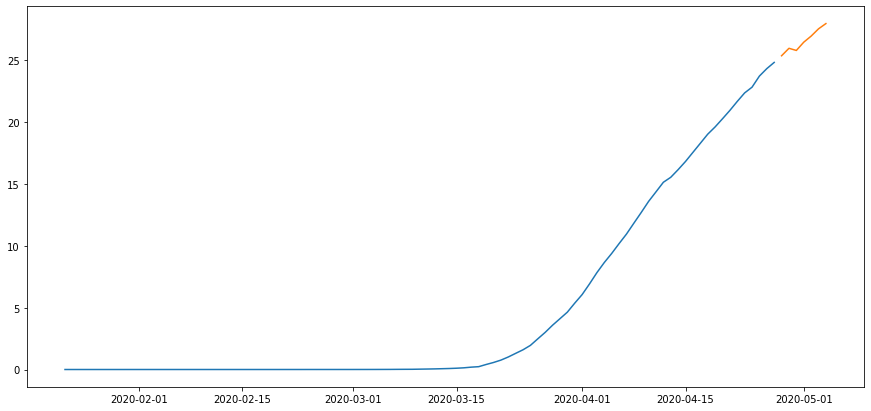

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'US'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Spain

COUNTRY:  Spain




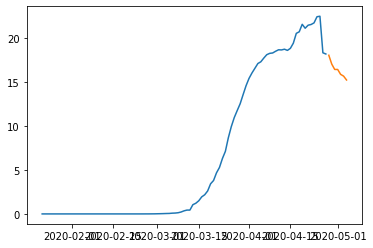

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Spain'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Italy

COUNTRY:  Italy




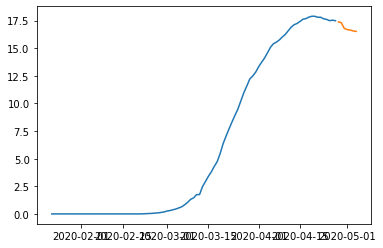

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Italy'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search UK

COUNTRY:  UK




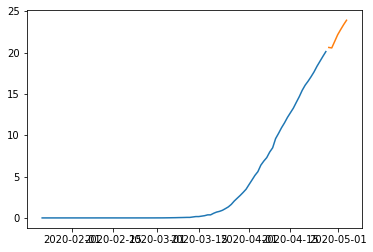

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'UK'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search France


COUNTRY:  France




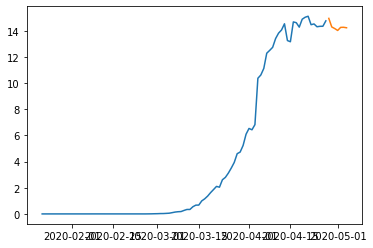

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'France'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Germany


COUNTRY:  Germany




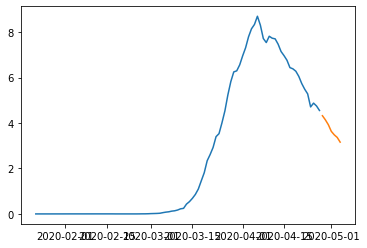

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Germany'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Russia


COUNTRY:  Russia




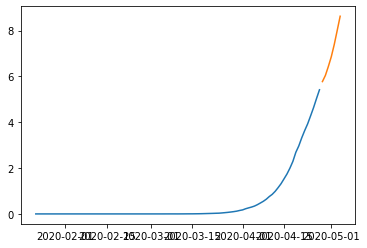

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Russia'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Turkey


COUNTRY:  Turkey




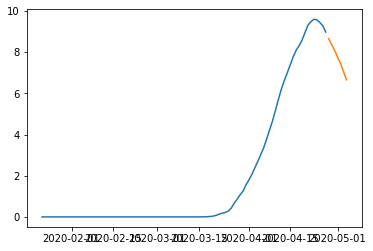

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Turkey'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Brazil


COUNTRY:  Brazil




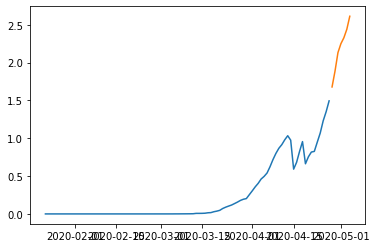

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Brazil'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Iran


COUNTRY:  Iran




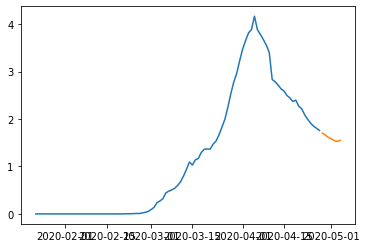

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Iran'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)

save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_joined(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#1/type#1(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

# Type#2

## Grid Search US

COUNTRY:  US




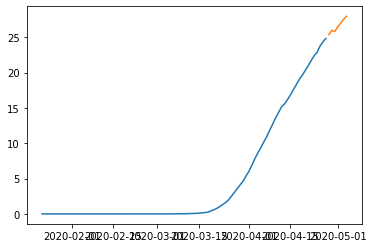

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'US'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Spain

COUNTRY:  Spain




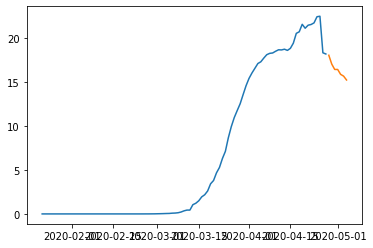

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Spain'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Italy

COUNTRY:  Italy




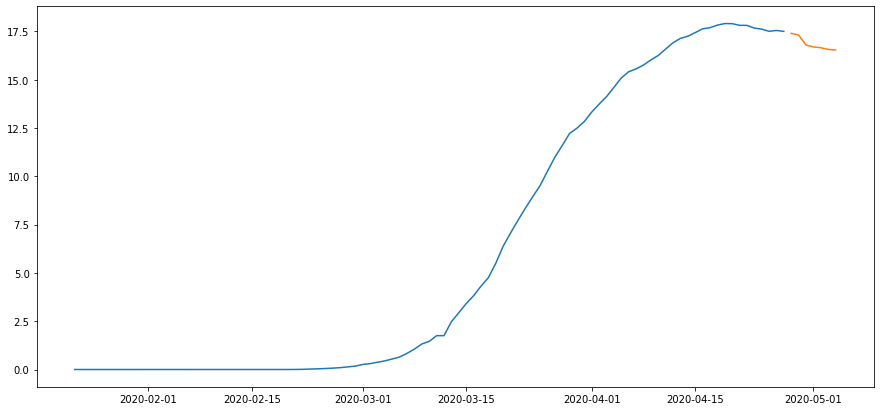

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Italy'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search UK

COUNTRY:  UK




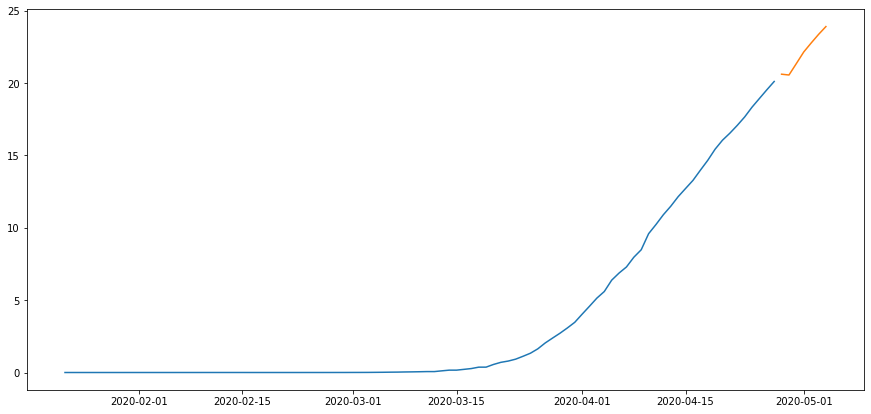

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'UK'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search France

COUNTRY:  France




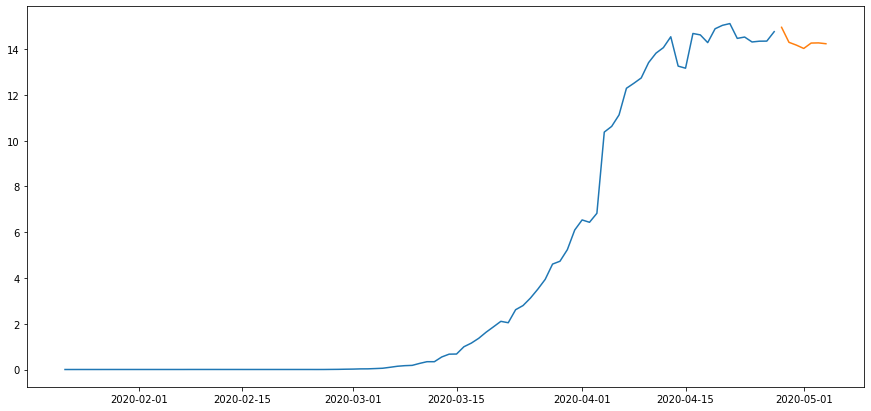

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'France'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Germany

COUNTRY:  Germany




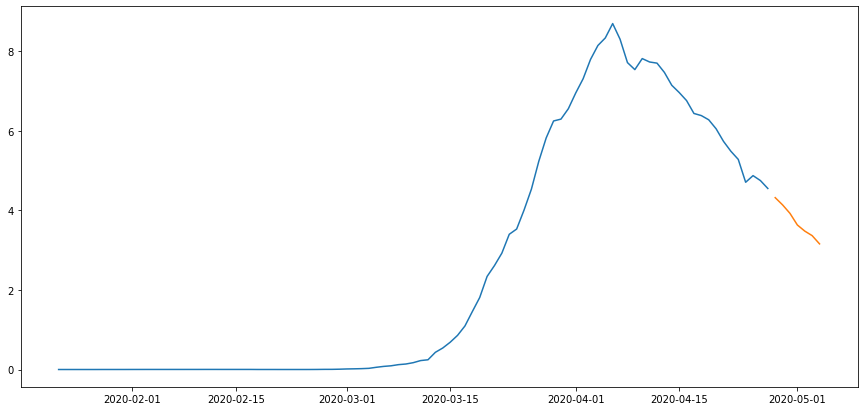

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Germany'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Russia

COUNTRY:  Russia




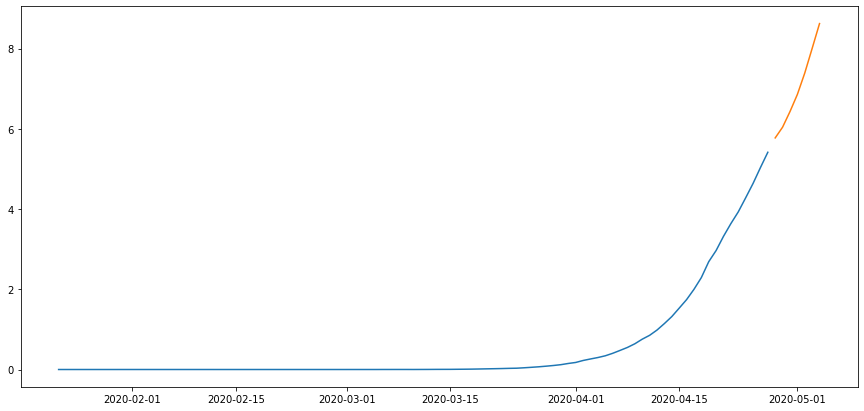

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Russia'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Turkey

COUNTRY:  Turkey




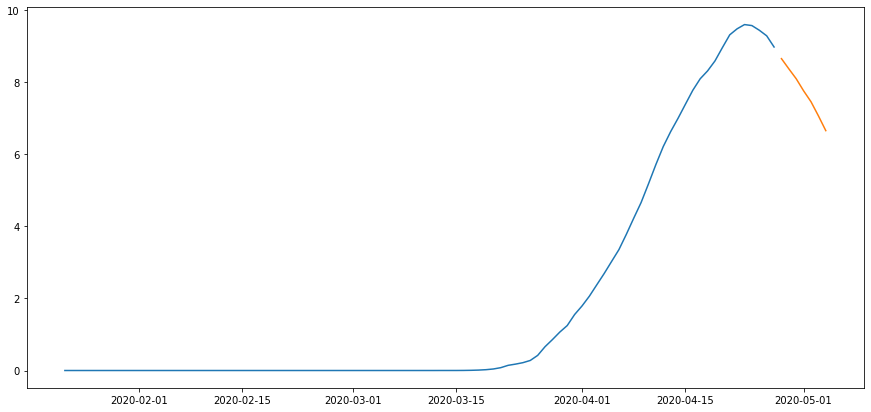

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Turkey'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Brazil

COUNTRY:  Brazil




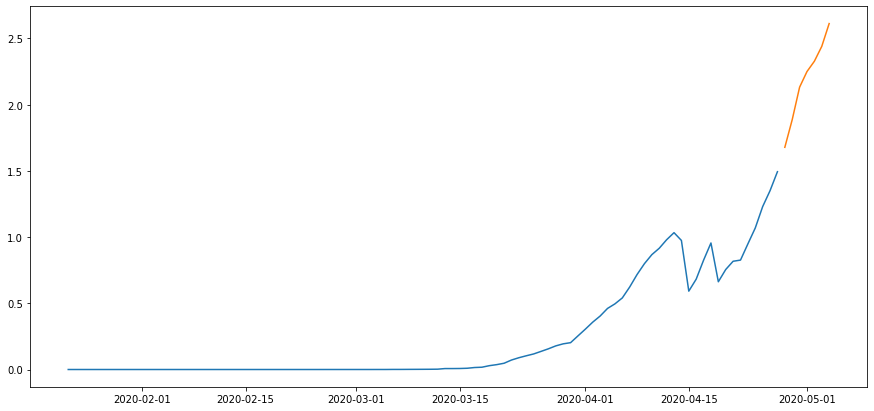

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Brazil'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Iran

COUNTRY:  Iran




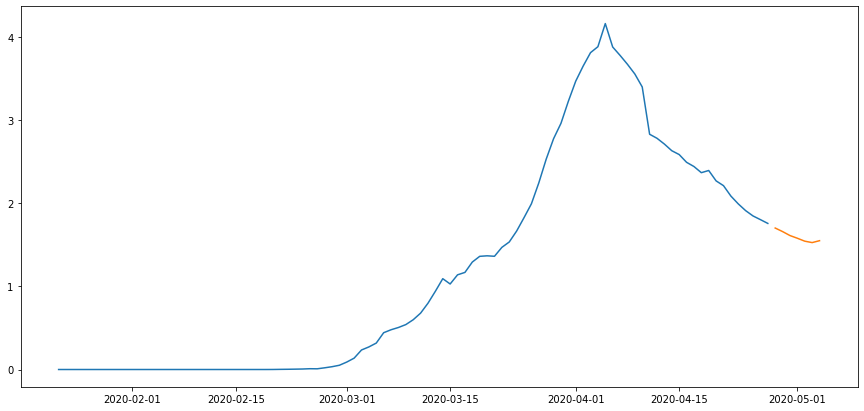

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Iran'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_decoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#2/type#2(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

# Type#3

## Grid Search US

COUNTRY:  US




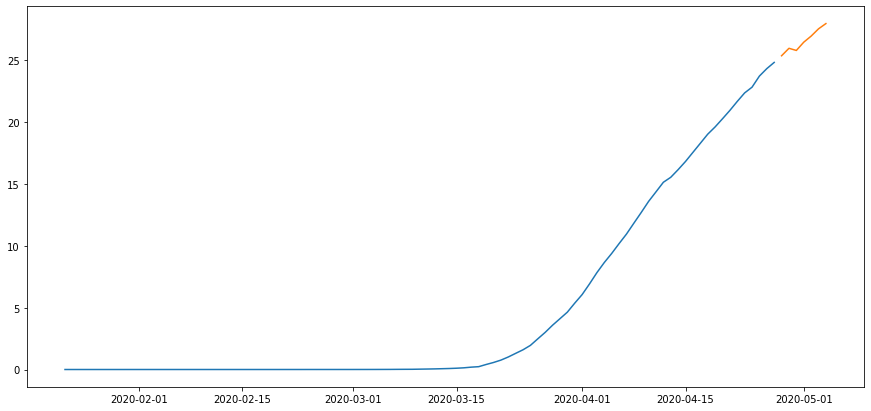

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'US'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Spain

COUNTRY:  Spain




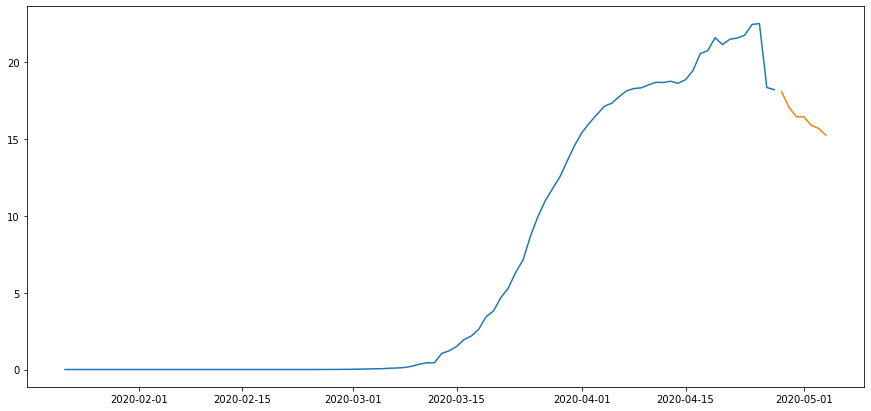

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Spain'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Italy

COUNTRY:  Italy




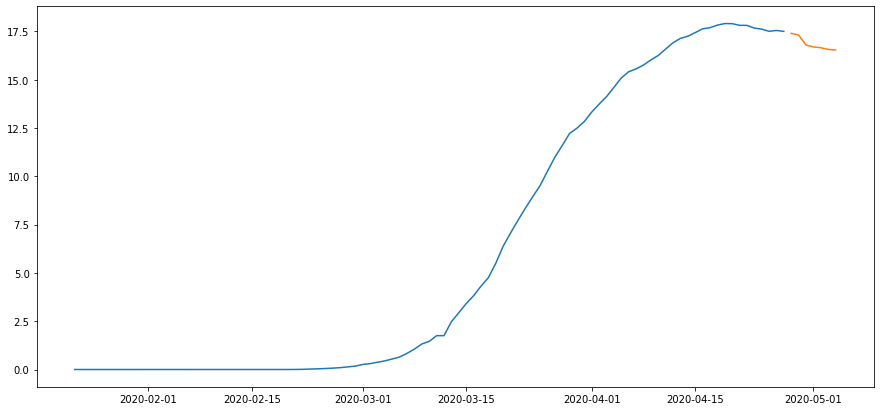

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Italy'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search UK

COUNTRY:  UK




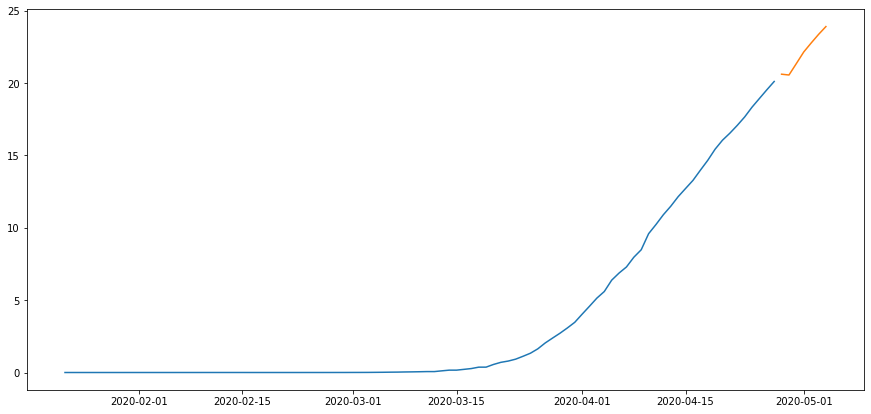

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'UK'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search France

COUNTRY:  France




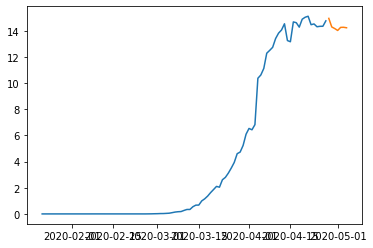

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'France'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Germany

COUNTRY:  Germany




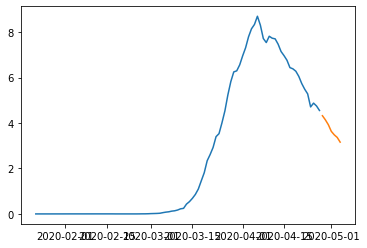

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Germany'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Russia


COUNTRY:  Russia




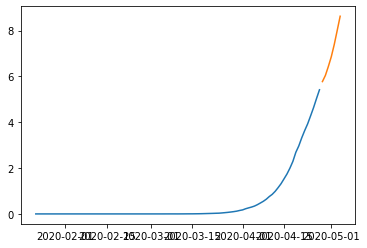

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Russia'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Turkey


COUNTRY:  Turkey




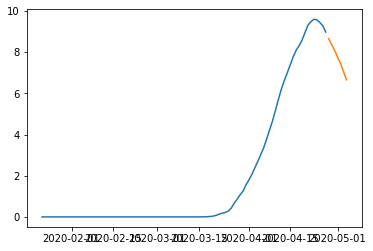

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Turkey'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Brazil


COUNTRY:  Brazil




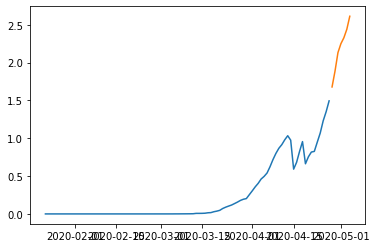

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Brazil'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)

## Grid Search Iran


COUNTRY:  Iran




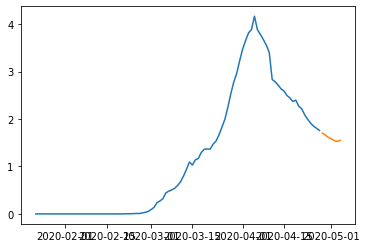

In [ ]:
forecast_len = 7
train, test = pd.DataFrame(), pd.DataFrame()
name = 'Iran'

df = top_n[top_n['country'] == name].set_index('date')['population_percentage'].reindex(date_range).fillna(0)

df_train = df.iloc[:-forecast_len]
df_test = df.iloc[-forecast_len:]

train['population_percentage'] = df_train*100
test['population_percentage'] = df_test*100

print("COUNTRY: ", name)
print("\n")

plt.plot(train)
plt.plot(test)
plt.show()

# Features for the network inputs
features = ['population_percentage']
# Features target to predict
targets_features = ['population_percentage']
# Window lenght for the input data
input_window = 7
# Desire prediction output lenght
forward_len = 7

prct_to_train = 0.75

learning_rate=0.001

input_nn = {"inseqlen": input_window,
            "outseqlen": forward_len,
            "growth": 4,
            "latent_space_dim": 7,
            "n_features": len(features),
            "n_targets": len(targets_features),
            "activation": 'ReLU',
            "epochs": 4000
            }


data_instance = DataManagement(train, features, targets_features, normalize_data=False)

#Creating the train and test datasets
data_instance.data_tensor_generate(input_window, forward_len)
# Train and tes split
data_instance.train_test_split(prct_to_train)
# Batch size for train
batch_s = int(len(data_instance.X_train)/3)
# Creating the data loaders for train and test
data_instance.dataloader_create(batch_s)
data_instance.data_split_by_feature()
save_json = {}

for idx, seed in enumerate(seeds):

    input_nn['seed'] = int(seed)
    model = ModifiedAutoEncoder(input_nn)

    model.loss_function = RMSELoss()
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train_splitted_freezing_autoencoders_weights(data_instance)

    # Creating the data for plot vizualization
    to_predict = torch.Tensor(np.array(test))
    # Getting the trained model prediction
    with torch.no_grad():
        dec, pred = model(to_predict.view(1, 1, 7))
    # Getting the numpy array by the torch Tensor
    pred_ = pred.view(-1).detach().numpy()/100
    # Getting the target features values from data
    test_data = test[targets_features].values.reshape(-1)/100
    # Getting metrics values (rmse of all data, and rmse for only test period)
    pred_rmse = np.sqrt(mean_squared_error(pred_, test_data))

    loss_vect = model.loss_train
    min_train_loss = min(loss_vect)
    epoch_min_train_loss = loss_vect.index(min_train_loss)

    loss_vect = model.loss_val
    min_val_loss = min(loss_vect)
    epoch_min_val_loss = loss_vect.index(min_val_loss)


    save_json["model_"+str(idx)] = {"seed": str(seed), "pred_rmse": pred_rmse,
                                    "min_train_loss": min_train_loss,
                                    "epoch_min_train_loss": epoch_min_train_loss,
                                    "min_val_loss": min_val_loss,
                                    "epoch_min_val_loss": epoch_min_val_loss
                                    }

with open("results/type#3/type#3(" + name + ")mae.json", "w") as fp:
    json.dump(save_json, fp, indent=3)